# CmdStanPy Tutorial


### Overview

Once you have specified your model(s) and have collected or generated some amount of data,
the CmdStanPy workflow consists of the following:

#### Compile Stan program - function `compile_model`
  + takes as input a Stan program and produces the corresponding c++ executable.
  + both Stan program and c++ executable exist as on-disk files

#### Assemble input data as either:
  + a Python `dict` object consisting of key-value pairs where the key corresponds
 to Stan data variables and the value is of the correct type and shape.
  + an existing data file on disk in either JSON or Rdump format.

#### Run sampler - function `sample`
  + invokes Stan's NUTS-HMC sampler to condition model on input data, produces output csv files
  + runs any number of chains - should run at least 2, default 4
  + lightweight object `RunSet` keeps track of sampler arguments, per-chain outcome, output files
  + returns `PosteriorSample` object which contains information about sample

#### Analyze resulting `PosteriorSample`
  + `PosteriorSample` contains names of csv output files, names of csv column headers
  + attribute `sample` assembles in-memory sample from csv files
  + methods `summary` and `diagnose` invoke CmdStan tools `bin/stansummary` and `bin/diagnose` respectively


### Installation

* Download this repo from GitHub

* run script `make_cmdstan.sh` - (need equivalent for Windows) - this installs and builds cmdstan in subdirectory `releases`




### Example 1:  Compiling and running example model `bernoulli.stan` in directory `test/data`

In [2]:
import os
import os.path
import tempfile
import numpy as np
from pandas import DataFrame
from cmdstanpy.lib import Model, RunSet, SamplerArgs, PosteriorSample
from cmdstanpy.cmds import compile_model, sample


Call `compile_model` with path to Stan program, returns `Model` object `bernoulli_model`

In [3]:
datafiles_path = os.path.expanduser(
    os.path.join("~", "github", "stan-dev", "cmdstanpy", "test", "files-data"))
stan = os.path.join(datafiles_path, "bernoulli.stan")
bernoulli_model = compile_model(stan)
print(bernoulli_model)

compile_model, CMDSTAN_PATH=/Users/mitzi/github/stan-dev/cmdstanpy/releases/cmdstan
Model(name=bernoulli,  stan_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/files-data/bernoulli.stan", exe_file="/Users/mitzi/github/stan-dev/cmdstanpy/test/files-data/bernoulli")


Specify data - JSON file on disk

In [4]:
jdata = os.path.join(datafiles_path, "bernoulli.data.json")

Call `sample` to run NUTS-HMC sampler, returns `PosteriorSample` object `a_sample`

In [5]:
a_sample = sample(bernoulli_model, chains=4, cores=2, data_file=jdata)

start chain 1.
start chain 2.


finish chain 2.

start chain 3.

finish chain 1.

start chain 4.

finish chain 3.

finish chain 4.



#### `PosteriorSample` object methods

print:

In [6]:
a_sample

PosteriorSample(chains=4,  draws=1000, columns=8)

Method `summary` returns output of CmdStan `bin/stansummary` as  pandas.DataFrame:

In [7]:
a_sample.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-7.267690,0.018608,0.693983,-8.767510,-6.990290,-6.749770,1390.9200,11690.0000,1.002170e+00
accept_stat__,0.917904,0.022527,0.142122,0.618264,0.975690,1.000000,39.8037,334.5300,1.047260e+00
stepsize__,0.919820,0.106882,0.151191,0.769726,0.893880,1.170190,2.0010,16.8174,1.256230e+14
treedepth__,1.499500,0.055308,0.602985,1.000000,1.000000,3.000000,118.8590,998.9500,1.025330e+00
n_leapfrog__,2.823500,0.239828,1.720050,1.000000,3.000000,7.000000,51.4379,432.3100,1.039010e+00
divergent__,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
energy__,7.771590,0.025623,0.991637,6.793990,7.471120,9.822710,1497.7800,12588.1000,1.000880e+00
theta,0.249754,0.003096,0.120223,0.081411,0.233435,0.474779,1507.6800,12671.3000,1.000460e+00


Function `diagnose` prints diagnostics to console:

In [8]:
a_sample.diagnose()

No problems detected.


In [9]:
a_sample.sample.shape

(1000, 4, 8)

Function `extract` flattens ndarray (draws X chains X columns) to pandas.DataFrame over columns

(Index(['lp__', 'accept_stat__', 'stepsize__', 'treedepth__', 'n_leapfrog__',
        'divergent__', 'energy__', 'theta'],
       dtype='object'), <matplotlib.axes._subplots.AxesSubplot at 0x11b369390>)

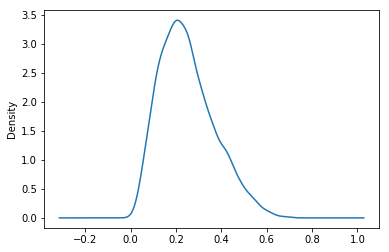

In [20]:
samp = a_sample.extract()
samp.columns, samp.theta.plot.density()